<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
# !conda activate cs685

In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
!git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection
Already on '5-bert-baselines-bin-classification-hate-non-hate'
Your branch is up to date with 'origin/5-bert-baselines-bin-classification-hate-non-hate'.


In [7]:
!git status

On branch 5-bert-baselines-bin-classification-hate-non-hate
Your branch is up to date with 'origin/5-bert-baselines-bin-classification-hate-non-hate'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Anaconda3-5.1.0-Linux-x86_64.sh
	implicit_hate_detection_hate_vs_non_hate.ipynb
	implicit_hate_detection_implicit_hate_vs_non_hate.ipynb
	implicit_hate_detection_multi.ipynb
	implicit_hate_detection_multi_class.ipynb
	model.h5

nothing added to commit but untracked files present (use "git add" to track)


install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [11]:
import os

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [12]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [13]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], merge_hate_labels=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Dataset size 21480
Dataset splits [12888, 4296, 4296]


In [14]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [15]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels, average='binary')
    class_names=['not_hate', 'hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [16]:
!wandb login 

wandb: Currently logged in as: psarda (use `wandb login --relogin` to force relogin)


In [17]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "original-ppr-hparams-sweep",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [2e-5, 3e-5, 5e-5]
        },
        "epochs" : {
            "values" : [1, 2, 3, 4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: jmtq2qq1
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/jmtq2qq1


In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")
            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(model, test_set, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: bf8ivcpp with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: Currently logged in as: psarda (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 832.2021599560976


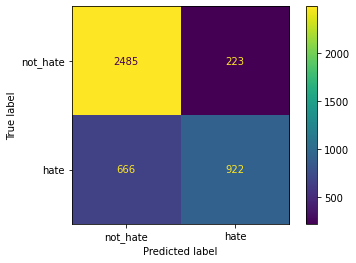

0.5806045340050378 0.8052401746724891 0.6747164288327845
Validation accuracy: 0.7930633147113594

Training complete!


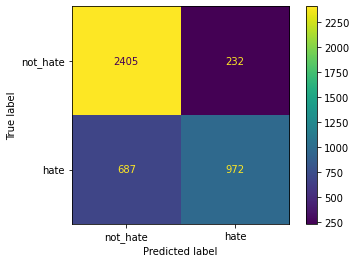

0.5858951175406871 0.8073089700996677 0.6790080335312608
Test accuracy: 0.7860800744878957


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▅▄▅▅▄▄▄▃▅▄▆▃▅▁▂▁▃▄▄▂▂▂▄▁▃█▄▂▁▃▅▂▇▅▂▂▄▅▃▂
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Agent Starting Run: yjidlicp with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 824.8116026595235


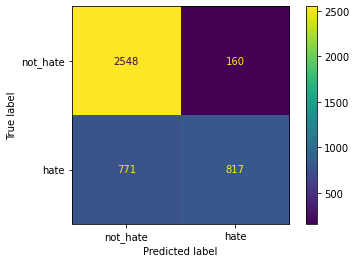

0.5144836272040302 0.8362333674513818 0.637037037037037
Validation accuracy: 0.7832867783985102

Training complete!


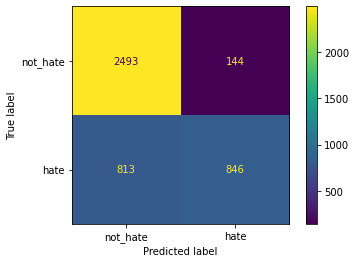

0.5099457504520796 0.8545454545454545 0.638731596828992
Test accuracy: 0.7772346368715084


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▆▃▆▅▄▄▄▃▅▅▇▃▆▁▃▁▂▅▄▂▂▂▄▁▃█▄▃▂▃█▂▆▄▂▂▄▆▃▂
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v73blsi1 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
Total loss: 848.6477458328009


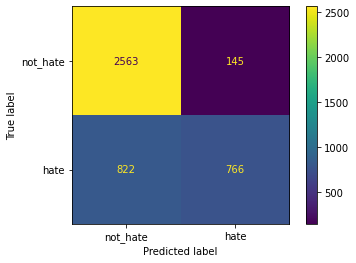

0.482367758186398 0.8408342480790341 0.613045218087235
Validation accuracy: 0.7749068901303539

Training complete!


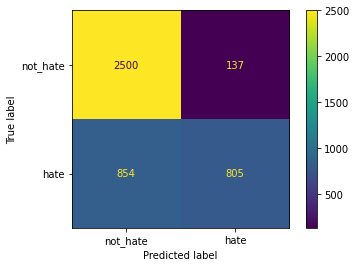

0.48523206751054854 0.8545647558386412 0.6189926951172626
Test accuracy: 0.7693202979515829


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▅▄▆▅▄▄▅▄▃▄▆▂▅▄▃▁▃▃▃▃▃▂▄▂▃█▅▃▂▃▇▃▅▄▁▃▄▇▃▃
epoch,▁
loss,▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁
val_f1,▁
val_precision,▁


wandb: Agent Starting Run: 19rwh1ia with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 826.181704159826


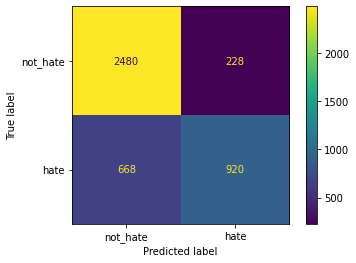

0.5793450881612091 0.8013937282229965 0.672514619883041
Validation accuracy: 0.7914338919925512

======== Epoch 2 / 2 ========
Training...
Total loss: 548.7772934157401


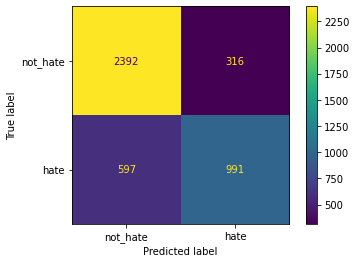

0.6240554156171285 0.7582249426166794 0.6846286701208981
Validation accuracy: 0.7874767225325885

Training complete!


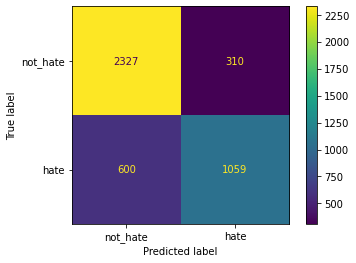

0.6383363471971067 0.7735573411249087 0.6994715984147953
Test accuracy: 0.7881750465549349


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
batch_loss,▆▆█▅▄█▄▃▄▆▃▄▆▂▂▄▇▄▆▆▄▃▃▄▆▃▁▄▃▅▂▄▁▅▂▄▄▄▂▇
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: 0cm8xl1r with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 830.3352696411312


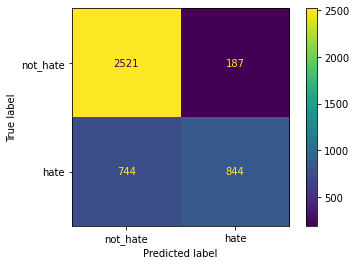

0.5314861460957179 0.8186226964112512 0.644520809469263
Validation accuracy: 0.7832867783985102

======== Epoch 2 / 2 ========
Training...
Total loss: 562.7873484836891


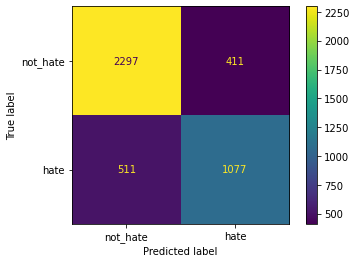

0.6782115869017632 0.7237903225806451 0.7002600780234071
Validation accuracy: 0.7853817504655494

Training complete!


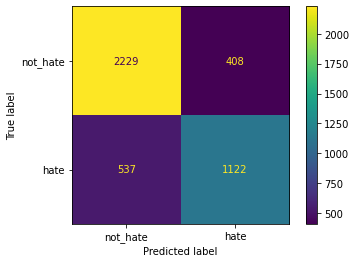

0.6763110307414105 0.7333333333333333 0.7036688617121355
Test accuracy: 0.7800279329608939


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
batch_loss,▅▅▆▅▅█▃▃▄▄▃▅▅▂▂▅▇▄▅▆▄▂▄▄▄▂▁▃▂▅▃▅▁▂▃▃▅▄▂▅
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: gfmko9zl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
Total loss: 849.1071312278509


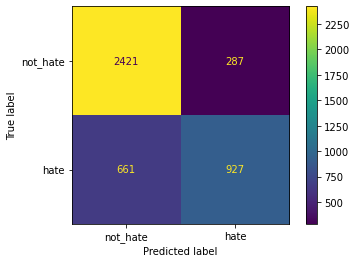

0.5837531486146096 0.7635914332784185 0.6616702355460385
Validation accuracy: 0.7793296089385475

======== Epoch 2 / 2 ========
Training...
Total loss: 618.8484708555043


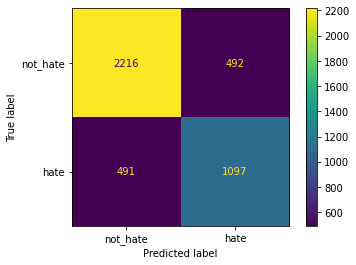

0.6908060453400504 0.6903713027061045 0.6905886056027699
Validation accuracy: 0.7711824953445066

Training complete!


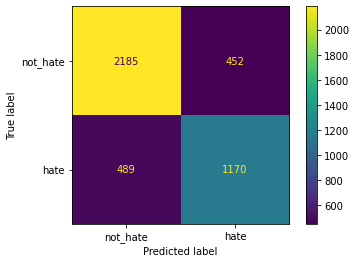

0.705244122965642 0.7213316892725031 0.7131971959768363
Test accuracy: 0.7809590316573557


batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
batch_loss,▅▇▆▅▆▇▅▄▄▅▄▆▅▁▂▃▆▃▅▅▄▂▃▄▄▃▁▄▂█▁▅▁▅▃▁▇▄▃▅
epoch,▁▁
loss,█▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁
val_f1,▁█
val_precision,▁█


wandb: Agent Starting Run: 2ozi6j9a with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 836.3064638152719


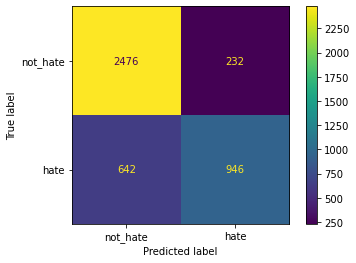

0.5957178841309824 0.8030560271646859 0.6840202458423716
Validation accuracy: 0.7965549348230913

======== Epoch 2 / 3 ========
Training...
Total loss: 569.9760801550001


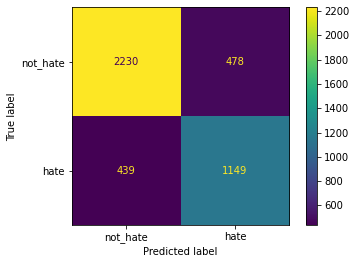

0.7235516372795969 0.7062077443146896 0.714774494556765
Validation accuracy: 0.7865456238361266

======== Epoch 3 / 3 ========
Training...
Total loss: 333.8202996926848


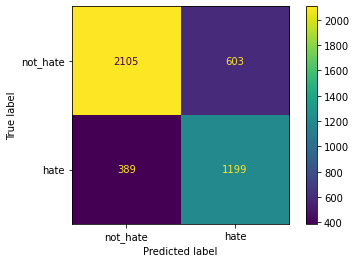

0.7550377833753149 0.6653718091009989 0.7073746312684366
Validation accuracy: 0.7690875232774674

Training complete!


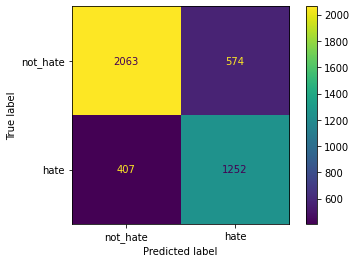

0.754671488848704 0.6856516976998904 0.7185078909612624
Test accuracy: 0.7716480446927374


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▄▅▆▆▇▇█▁▂▂▃▃▄▄▅▆▆▇▇█
batch_loss,▅▅▅▄▄▄▅▆█▂▅▅▄▃▃█▇▃▄▅▅▄▃▂▅▅▂▁▅▄▁▃▁▄▂▅▃▁▂▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▅▁
val_f1,▁█▆
val_precision,▁▇█


wandb: Agent Starting Run: q7j0f1nx with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 831.8099689558148


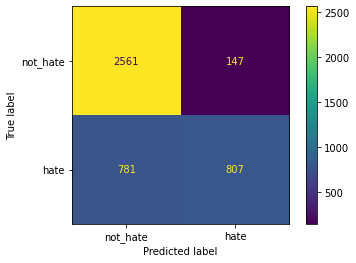

0.5081863979848866 0.8459119496855346 0.6349331235247836
Validation accuracy: 0.7839851024208566

======== Epoch 2 / 3 ========
Training...
Total loss: 561.6401845756918


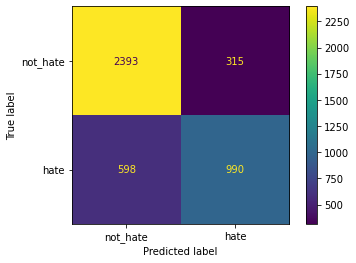

0.6234256926952141 0.7586206896551724 0.6844106463878327
Validation accuracy: 0.7874767225325885

======== Epoch 3 / 3 ========
Training...
Total loss: 304.7266427848954


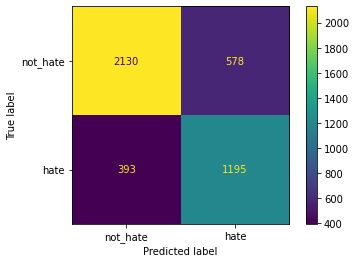

0.7525188916876574 0.6739988719684151 0.7110978875334721
Validation accuracy: 0.773975791433892

Training complete!


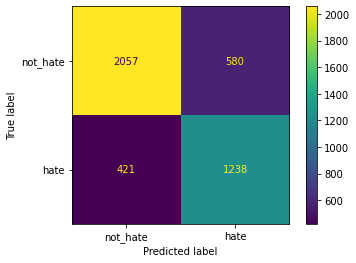

0.7462326702833032 0.680968096809681 0.7121081392004601
Test accuracy: 0.7669925512104283


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▄▅▆▆▇▇█▁▂▂▃▃▄▄▅▆▆▇▇█
batch_loss,▆▆▆▃▄▄▇▄█▃▅▅▅▄▂▇▆▃▂▅▆▃▄▂▅▄▄▁▆▂▁▄▂▄▂▂▄▁▁▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▆█▁
val_f1,▁▆█
val_precision,▁▄█


wandb: Agent Starting Run: az77eptg with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
Total loss: 851.2564885243773


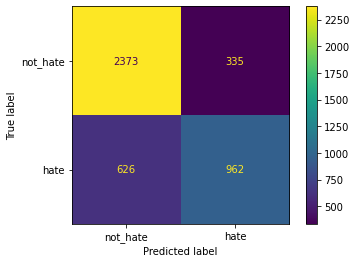

0.6057934508816121 0.7417116422513492 0.666897746967071
Validation accuracy: 0.7763035381750466

======== Epoch 2 / 3 ========
Training...
Total loss: 611.1625931616873


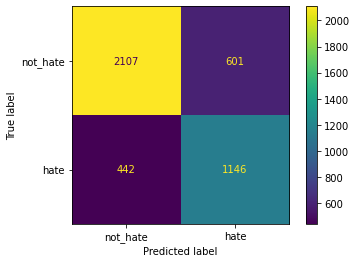

0.7216624685138538 0.6559816828849456 0.6872563718140929
Validation accuracy: 0.7572160148975792

======== Epoch 3 / 3 ========
Training...
Total loss: 405.9301450699568


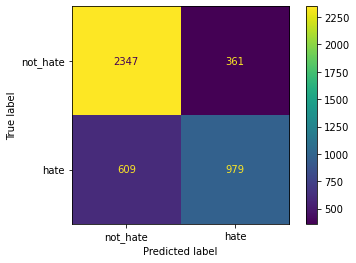

0.6164987405541562 0.7305970149253731 0.6687158469945356
Validation accuracy: 0.7742085661080075

Training complete!


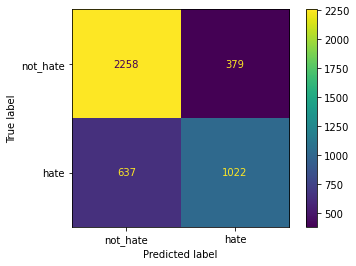

0.6160337552742616 0.729478943611706 0.6679738562091504
Test accuracy: 0.7635009310986964


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▄▅▆▆▇▇█▁▂▂▃▃▄▄▅▆▆▇▇█
batch_loss,▆▆▆▄▅▄▆▆█▃▆▆▆▅▃▇▆▄▂▆▆▄▅▁▅▃█▁▄▄▂▂▂▆▂▄▃▂▂▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁▇
val_f1,▁█▂
val_precision,▁█▂


wandb: Agent Starting Run: 0yd4ncb8 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 823.5106035917997


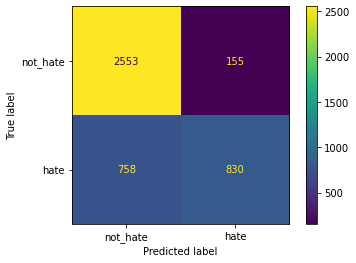

0.5226700251889169 0.8426395939086294 0.6451612903225806
Validation accuracy: 0.7874767225325885

======== Epoch 2 / 4 ========
Training...
Total loss: 546.5226911874488


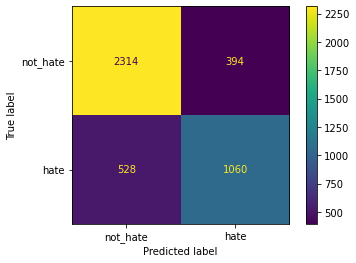

0.6675062972292192 0.7290233837689133 0.6969099276791585
Validation accuracy: 0.7853817504655494

======== Epoch 3 / 4 ========
Training...
Total loss: 297.4789531819988


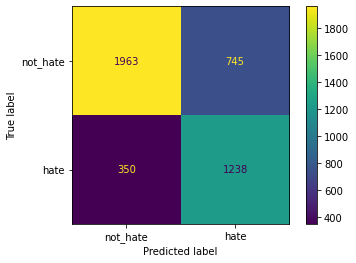

0.7795969773299748 0.6243066061522945 0.69336320358443
Validation accuracy: 0.7451117318435754

======== Epoch 4 / 4 ========
Training...
Total loss: 176.33297620504163


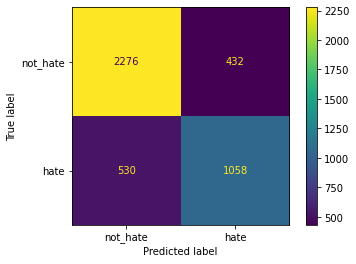

0.6662468513853904 0.7100671140939597 0.6874593892137751
Validation accuracy: 0.7760707635009311

Training complete!


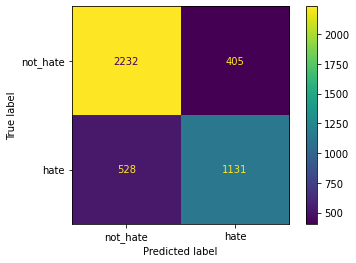

0.6817359855334539 0.736328125 0.7079812206572771
Test accuracy: 0.7828212290502793


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▅▃▄▅▃▇▂▄▄▃▄▆▂▃█▁▁▄▂▃▄▂▃▁▁▂▃▂▁▁▁▃▁▁▂▁▃▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,██▁▆
val_f1,▁██▇
val_precision,▁▅█▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: maunlww1 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 826.800877738744


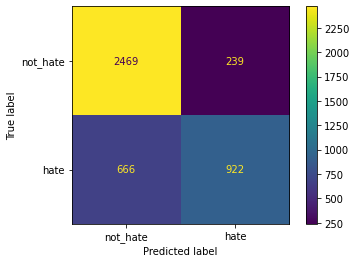

0.5806045340050378 0.7941429801894918 0.6707893779556202
Validation accuracy: 0.7893389199255121

======== Epoch 2 / 4 ========
Training...
Total loss: 555.4535270258784


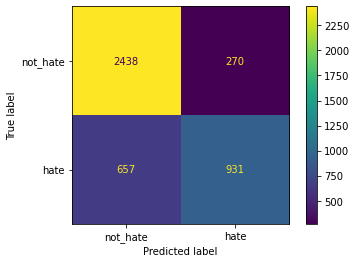

0.586272040302267 0.7751873438800999 0.6676228038723557
Validation accuracy: 0.784217877094972

======== Epoch 3 / 4 ========
Training...
Total loss: 324.6788617230486


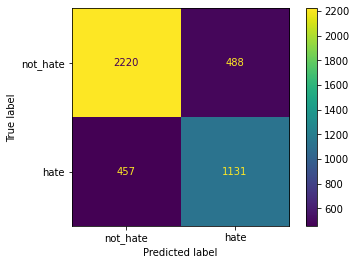

0.7122166246851386 0.6985793699814701 0.70533208606174
Validation accuracy: 0.7800279329608939

======== Epoch 4 / 4 ========
Training...
Total loss: 187.90137130813673


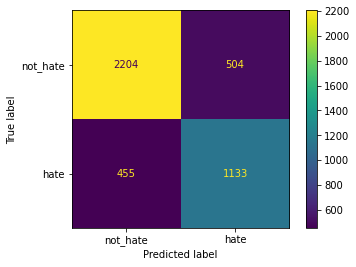

0.7134760705289672 0.6921197312156384 0.7026356589147287
Validation accuracy: 0.7767690875232774

Training complete!


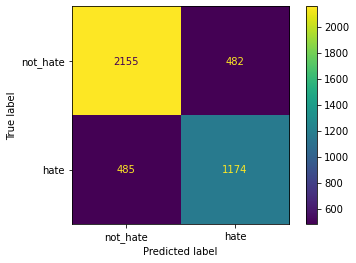

0.707655213984328 0.7089371980676329 0.7082956259426848
Test accuracy: 0.7749068901303539


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▇▅▆▅▄█▃▆█▃▅▆▂▃█▂▂▆▂▂▄▁▃▂▁▃▄▂▃▁▁▂▁▁▁▁▆▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▅▃▁
val_f1,▂▁█▇
val_precision,▁▁██


wandb: Agent Starting Run: omaghzzv with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 871.8257481083274


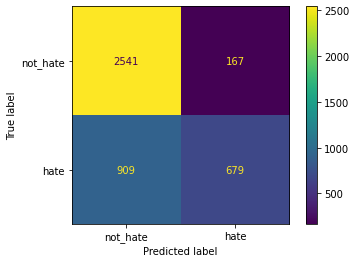

0.4275818639798489 0.8026004728132388 0.5579293344289236
Validation accuracy: 0.749534450651769

======== Epoch 2 / 4 ========
Training...
Total loss: 653.848522791639


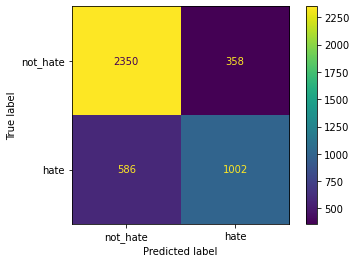

0.6309823677581864 0.736764705882353 0.6797829036635007
Validation accuracy: 0.7802607076350093

======== Epoch 3 / 4 ========
Training...
Total loss: 448.91452383995056


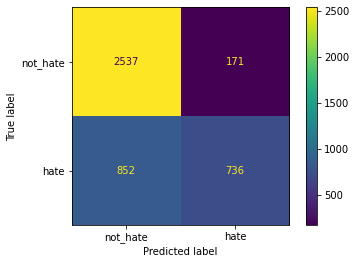

0.4634760705289673 0.8114663726571113 0.5899799599198398
Validation accuracy: 0.7618715083798883

======== Epoch 4 / 4 ========
Training...
Total loss: 311.43884742376395


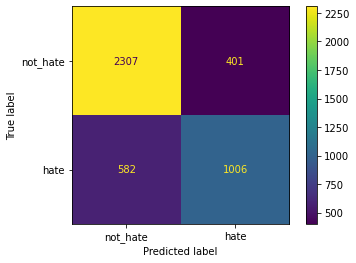

0.6335012594458438 0.7149964463397299 0.6717863105175292
Validation accuracy: 0.7711824953445066

Training complete!


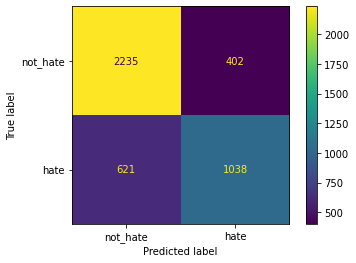

0.6256781193490054 0.7208333333333333 0.6698935140367861
Test accuracy: 0.7618715083798883


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▆▅▄▄▃█▂▅▆▃▃▆▅▄▇▁▁▆▃▂▄▂▃▃▁▆▅▄▃▁▁▁▅▁▂▅▄▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▄▆
val_f1,▁█▃█
val_precision,▁█▂█


In [19]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")